In [1]:
import numpy as np
from numpy import unravel_index
import nltk
from nltk.stem import PorterStemmer
from nltk.classify import MaxentClassifier
from tqdm import tqdm
import pickle
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

In [2]:
def import_Train_Data():
	ftrain = open("./CRF/assignment2dataset/train.txt")
	lines = ftrain.readlines()

	Sentences = []
	Sentence_Construct = []
	for line in lines:
		if line =='\n':
			Sentences.append(Sentence_Construct)
			Sentence_Construct = []

		else:
			Sentence_Construct.append(line)

	ftrain.close()
	return Sentences


def import_Test_Data():
	ftest = open("./CRF/assignment2dataset/test.txt")
	lines = ftest.readlines()

	Sentences = []
	Sentence_Construct = []
	for line in lines:
		if line =='\n':
			Sentences.append(Sentence_Construct)
			Sentence_Construct = []

		else:
			Sentence_Construct.append(line)

	ftest.close()
	return Sentences


def Remove_Extra_Tag(Sentences):

	Final_Sentences = []

	for line in Sentences:

		##Adding start tag
		Final_Line = []

		for word in line:
			Split_Term = word.split(" ")

			if "-" in Split_Term[2]:
				Final_Word = Split_Term[0]+" "+Split_Term[1]+" "+Split_Term[2].split("-")[0]
				Final_Line.append(Final_Word)

			else:
				Final_Line.append(word[:-1])

		Final_Sentences.append(Final_Line)

	return Final_Sentences

def Get_Tagset(Sentences):

	TagSet = []

	for sentence in Sentences:
		for word in sentence:
			TagSet.append(word.split(" ")[2])

	return set(TagSet)


In [3]:
!unzip CRF.zip

Archive:  CRF.zip
   creating: CRF/
  inflating: CRF/CRF-chunking.py     
   creating: CRF/assignment2dataset/
  inflating: CRF/assignment2dataset/README  
  inflating: CRF/assignment2dataset/test.txt  
  inflating: CRF/assignment2dataset/train.txt  


In [4]:
def build_labelled_features(Sentences):

	####Feature Set being used
	# 3 POS tags -> PrevtopPrev Prev Current 
	# 2 chunk labels -> PrevtoPrev Prev
	# 3  word-stems -> PrevtoPrev Prev Current => Stems
	# Morphological Features -> isCaptital

	labelled_features = []
	
	for sentence in Sentences:

		for word_index in range(0,len(sentence)):

			split_sentence = sentence[word_index].split(" ")

			if word_index == 0:
				# print(sentence[word_index])
				cur_chunk = split_sentence[2]
				prev_to_prev_POS = 'st'
				prev_POS = 'st'
				cur_POS = split_sentence[1]
				prev_to_prev_chunk = 'st'
				prev_chunk = 'st'
				cur_stem = split_sentence[0].lower()
				prev_stem = 'st'
				prev_to_prev_stem = 'st'
				suffix = split_sentence[0].lower().replace(os.path.commonprefix([PorterStemmer().stem(cur_stem), split_sentence[0].lower()]),'')


			elif word_index == 1:
				# print(sentence[word_index])
				prev_split = sentence[word_index-1].split(" ")

				cur_chunk = split_sentence[2]
				prev_to_prev_POS = 'st'
				prev_POS = prev_split[1]
				cur_POS = split_sentence[1]
				prev_to_prev_chunk = 'st'
				prev_chunk = prev_split[2]
				cur_stem = split_sentence[0].lower()
				prev_stem = prev_split[0].lower()
				prev_to_prev_stem = 'st'
				suffix = split_sentence[0].lower().replace(os.path.commonprefix([PorterStemmer().stem(cur_stem), split_sentence[0].lower()]),'')

				
			else:
				prev_split1 = sentence[word_index-1].split(" ")
				prev_split2 = sentence[word_index-2].split(" ")

				cur_chunk = split_sentence[2]
				prev_to_prev_POS = prev_split2[1]
				prev_POS = prev_split1[1]
				cur_POS = split_sentence[1]
				prev_to_prev_chunk = prev_split2[2]
				prev_chunk = prev_split1[2]
				cur_stem = split_sentence[0].lower()
				prev_stem = prev_split1[0].lower()
				prev_to_prev_stem = prev_split2[0].lower()
				suffix = split_sentence[0].lower().replace(os.path.commonprefix([PorterStemmer().stem(cur_stem), split_sentence[0].lower()]),'')


			labelled_item = cur_chunk, prev_to_prev_POS, prev_POS, cur_POS, prev_to_prev_chunk, prev_chunk, cur_stem, prev_stem, prev_to_prev_stem, suffix
			labelled_features.append(labelled_item)

	return labelled_features


In [5]:
Train_Sentences = import_Test_Data()
Test_Sentences = import_Train_Data()

Train_Sentences = Remove_Extra_Tag(Train_Sentences)
Test_Sentences = Remove_Extra_Tag(Test_Sentences)

In [6]:
Set_of_Tags = sorted(list(Get_Tagset(Train_Sentences)))
# Set_of_Tags.append('st')
indextags = {}

for tag_ind in range(0,len(Set_of_Tags)):
    indextags[Set_of_Tags[tag_ind]] = tag_ind


In [7]:
indexwords = {}
indexpos = {}
for i in range(len(Train_Sentences)):
    for j in (Train_Sentences[i]):
        j = j.split(' ')
        word = j[0]
        tag = j[1]
        if word not in indexwords.keys():
          indexwords[word] = len(indexwords)
        if tag not in indexpos.keys():
          indexpos[tag] = len(indexpos)
indexwords['oov'] = len(indexwords)
indexpos['oov'] = len(indexpos)

In [ ]:
indexwords['oov']

8118

In [ ]:
indexpos

{'#': 42,
 '$': 23,
 "''": 33,
 '(': 34,
 ')': 35,
 ',': 17,
 '.': 14,
 ':': 29,
 'CC': 19,
 'CD': 13,
 'DT': 5,
 'EX': 32,
 'FW': 40,
 'IN': 9,
 'JJ': 6,
 'JJR': 25,
 'JJS': 30,
 'MD': 27,
 'NN': 2,
 'NNP': 0,
 'NNPS': 26,
 'NNS': 12,
 'PDT': 41,
 'POS': 1,
 'PRP': 4,
 'PRP$': 8,
 'RB': 20,
 'RBR': 24,
 'RBS': 39,
 'RP': 37,
 'TO': 10,
 'UH': 38,
 'VB': 11,
 'VBD': 3,
 'VBG': 7,
 'VBN': 18,
 'VBP': 16,
 'VBZ': 15,
 'WDT': 21,
 'WP': 22,
 'WP$': 36,
 'WRB': 28,
 '``': 31}

In [8]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, indexwords, indexpos, indextags, dataset_list):
        self.indexwords = indexwords.copy()
        self.indextags = indextags
        self.dataset_list = dataset_list
        self.indexpos = indexpos

    def __getitem__(self, item):

        sent = self.dataset_list[item]
        wid = []
        tagid = []
        pid = []
        for i in sent:
            i = i.split(' ')
            word = i[0]
            tag = i[1]
            if word not in self.indexwords.keys():
                word = 'oov'
            if tag not in self.indexpos.keys():
                tag = 'oov'
            wid.append(self.indexwords[word])
            pid.append(self.indexpos[tag])
            tagid.append(self.indextags[i[2]])
        assert len(wid)==len(tagid)
        # print(len(tagid))
        return torch.LongTensor(wid), torch.LongTensor(pid), torch.LongTensor(tagid)

    def __len__(self):
        return len(self.dataset_list)


In [9]:
gpu = 0
device = torch.device(gpu if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(gpu)
print(device)

cuda:0


In [10]:
BATCH_SIZE = 1

In [11]:
train_set = MyData(indexwords, indexpos, indextags, Train_Sentences)
train_set, val_set = torch.utils.data.random_split(train_set, [int(0.8*len(train_set)), len(train_set)-int(0.8*len(train_set))] )
train_set = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_set = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


In [12]:
class BiLSTMNet(nn.Module):
  def __init__(self, hidden_dim, num_words, numpostags, n_layers=1, numTags=3):
    super(BiLSTMNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.embeddings = nn.Embedding(num_words, hidden_dim)
    self.embeddings2 = nn.Embedding(numpostags, hidden_dim)
    self.bilstm = nn.LSTM(2*hidden_dim, hidden_dim, n_layers, batch_first=True, bidirectional = True)
    self.fc = nn.Linear(hidden_dim*2,numTags)
    self.dropout = nn.Dropout(0.3)
    self.softmax = nn.Softmax(dim=2)

  def forward(self,x,y):
    x = self.embeddings(x)
    y = self.embeddings2(y)
    x = torch.cat([x,y], dim=-1)
    unpacked, (h_n, c_n) = self.bilstm(x)
    out = self.fc(unpacked)
    out = self.dropout(out)
    return self.softmax(out)

In [13]:
# loss_criteria = nn.BCELoss()
loss_criteria = nn.CrossEntropyLoss()
model = BiLSTMNet(1024, len(indexwords), len(indexpos))
# model = BiLSTMNet(64, len(indexwords))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
epochs = 15

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
# model.train()

for epoch in range(epochs):
    total_loss = 0
    train_acc = 0
    count = 0
    model.train()
    for (x,t,y) in train_set:
        # print(x.shape, y.shape)
        optimizer.zero_grad()
        out = model(x.to(device), t.to(device))
        # print(out.shape)
        loss = loss_criteria(out[0], y[0].to(device))
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        total_loss += loss.item()
        # print(torch.argmax(out, dim=-1).detach().numpy())
        # print(y)
        train_acc += accuracy_score(y[0].detach().cpu().numpy(),torch.argmax(out, dim=-1).detach().cpu().numpy()[0])*len(x)
        count+=len(x)
    
    print(f"Training loss for epoch {epoch+1}: {total_loss/count}")
    print(f"Training accuracy for epoch {epoch+1}: {train_acc/count*100}%")
    model.eval()
    total_loss = 0
    val_acc = 0
    count = 0
    for (x,t,y) in val_set:
        
        out = model(x.to(device), t.to(device))
        loss = loss_criteria(out[0], y[0].to(device))
        
        total_loss += loss.item()
        val_acc += accuracy_score(y[0].detach().cpu().numpy(),torch.argmax(out, dim=-1).detach().cpu().numpy()[0])*len(x)
        count+=len(x)
    
    print(f"Validation loss for epoch {epoch+1}: {total_loss/count}")
    print(f"Validation accuracy for epoch {epoch+1}: {val_acc/count*100}%")
    print('='*20)

Training loss for epoch 1: 0.7898152462438888
Training accuracy for epoch 1: 77.62030548519486%
Validation loss for epoch 1: 0.6528339516140391
Validation accuracy for epoch 1: 91.29913894231132%
Training loss for epoch 2: 0.6917241815456772
Training accuracy for epoch 2: 84.7753365476246%
Validation loss for epoch 2: 0.622033098495332
Validation accuracy for epoch 2: 93.65565134421782%
Training loss for epoch 3: 0.6717590409972936
Training accuracy for epoch 3: 86.2306019783628%
Validation loss for epoch 3: 0.6140512546002125
Validation accuracy for epoch 3: 94.16566549831357%
Training loss for epoch 4: 0.6637530616531467
Training accuracy for epoch 4: 87.10936252256111%
Validation loss for epoch 4: 0.6105941179076732
Validation accuracy for epoch 4: 94.36224270827131%
Training loss for epoch 5: 0.6597897608951429
Training accuracy for epoch 5: 86.96860620788549%
Validation loss for epoch 5: 0.6073829337917546
Validation accuracy for epoch 5: 94.57107706808917%
Training loss for epoch

In [16]:
test_set = MyData(indexwords, indexpos, indextags, Test_Sentences)
test_set = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


In [18]:
model.eval()
total_loss = 0
test_acc = 0
count = 0
preds = []
gold = []
for (x,t,y) in test_set:
    
    out = model(x.to(device), t.to(device))
    loss = loss_criteria(out[0], y[0].to(device))
    
    total_loss += loss.item()
    gold.extend(y[0].detach().cpu().numpy())
    preds.extend(torch.argmax(out, dim=-1).detach().cpu().numpy()[0])
    test_acc += accuracy_score(y[0].detach().cpu().numpy(),torch.argmax(out, dim=-1).detach().cpu().numpy()[0])*len(x)
    count+=len(x)

print(f"Test loss : {total_loss/count}")
print(f"Test accuracy : {test_acc/count*100}%")

Test loss : 0.5982996001772936
Test accuracy : 95.33008598394144%


In [20]:
print(accuracy_score(gold,preds))

0.9525993378265408


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(gold,preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    106978
           1       0.96      0.92      0.94     76847
           2       0.95      0.96      0.95     27902

    accuracy                           0.95    211727
   macro avg       0.95      0.95      0.95    211727
weighted avg       0.95      0.95      0.95    211727



[[104230   2506    242]
 [  4985  70723   1139]
 [   562    602  26738]]


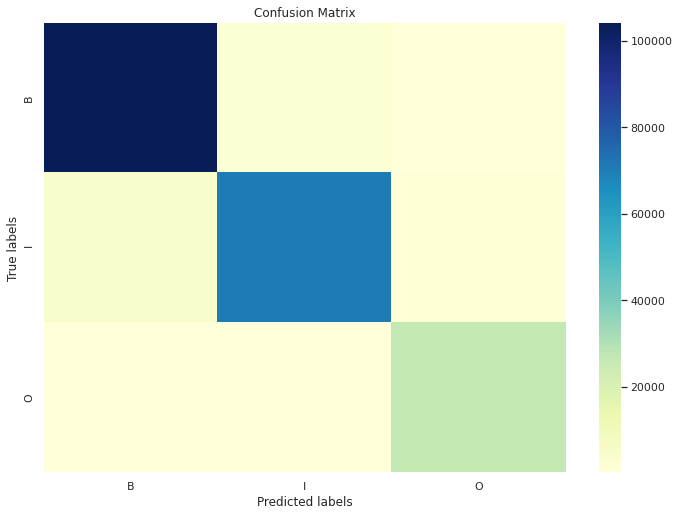

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt  

cm = confusion_matrix(gold, preds, list(indextags.values()))
print(cm)

sns.set(rc={'figure.figsize':(11.7,8.27)})


ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax,cmap="YlGnBu")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(list(indextags.keys()))
ax.yaxis.set_ticklabels(list(indextags.keys()));
plt.show()